Главная задача:
Подпишет ли клиент срочный депозит?

Задача прогнозирования с бинарным ответом.

In [1]:
#импорт библиотек
import numpy as np
import pandas as pd

#визуализация
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import os

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
#импорт датасета

df = pd.read_csv('/home/aliya/bank.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Описание датасета:

Входные переменные:

данные клиента:
- age - возраст 
- job - работа: тип работы («администратор», «рабочий», «предприниматель», «домработница», «менеджер», «пенсионер», «работающий не по найму», «услуги», «студент», «безработный», «неизвестно»)
- marital -семейное положение: семейное положение («в разводе», «замужем», «не замужем», «неизвестно»)
- education - образование («базовый 4 года», «базовый 6 лет», «базовый 9 лет», «старшая школа», «неграмотный», «профессиональный курс», «университетский диплом», «неизвестный»)
- default - есть ли кредит? («нет», «да», «неизвестно»)
- housing - жилье: есть ли жилищный кредит? («нет», «да», «неизвестно»)
- loan - кредит: есть личный кредит? (категорически: «нет», «да», «неизвестно»)

связанный с последним контактом текущей кампании:
- contact - тип контактной связи («сотовый», «телефонный»)
- month - последний контактный месяц года («январь», «февраль», «мар», ..., «ноябрь», «декабрь»)
- day_of_week - последний контактный день недели (понедельник, вторник, среда, четверг, пятница)
- duration - длительность последнего контакта в секундах (числовая). 

социально-экономические атрибуты контекста
- emp.var.rate - коэффициент изменения занятости - квартальный показатель (числовой)
- cons.price.idx - индекс потребительских цен - месячный показатель (числовой)
- cons.conf.idx - индекс доверия потребителей - месячный показатель (числовой)
- euribor3m - ставка за 3 месяца - дневной показатель (числовой)
- nr.employed - количество сотрудников - квартальный показатель (числовой)

другие атрибуты:
- campaign - количество контактов, выполненных во время этой кампании и для этого клиента (числовое, включая последний контакт)
- pdays - количество дней, прошедших после последнего контакта с клиентом из предыдущей кампании (числовое значение; 999 означает, что с клиентом ранее не связывались)
- previous - количество контактов, выполненных до этой кампании и для этого клиента (числовое)
- poutcome -результат предыдущей маркетинговой кампании (категориальный: «провал», «несуществующий», «успех»)

Выходная переменная (желаемая цель):
- y - подписал ли клиент срочный депозит? (бинарный: «да», «нет»)

In [4]:
#посмотрим типы

df.dtypes.sort_values()

age           int64
previous      int64
pdays         int64
campaign      int64
duration      int64
balance       int64
day           int64
month        object
contact      object
loan         object
housing      object
default      object
education    object
marital      object
job          object
poutcome     object
deposit      object
dtype: object

In [5]:
#первично проанализаруем данные

df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [6]:
# узнаем количество строк

print("Датасет состоит из {rows} строк.".format(rows = len(df)))

Датасет состоит из 11162 строк.


In [7]:
#проверим наличие пропусков
missing_values = df.isnull().mean()*100

missing_values.sum()

0.0

Нам повезло, что в датасете нет пропусков, так как иначе пришлось бы заменять их на среднее значение, медиану или моду.
- Среднее значение = сумма всех значений/кол-во значений
- Медиана = среднее между минимумом и максимумом
- Мода = наиболее часто встречающееся значение

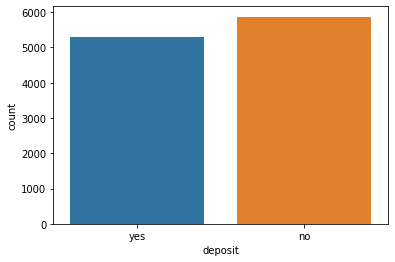

In [8]:
# оценим баланс выходной переменной
sns.countplot(x='deposit',data=df)

In [9]:
df.deposit.value_counts()/df.deposit.count()

no     0.52616
yes    0.47384
Name: deposit, dtype: float64

Значения для «да» и «нет» для депозита достаточно близки, поэтому мы можем использовать точность в качестве метрики для модели, которая прогнозирует результат.

Теперь нам нужно более подробно проанализировать датасет на наличие аномалий и выбросов. Сначала рассмотрим категориальные переменные.

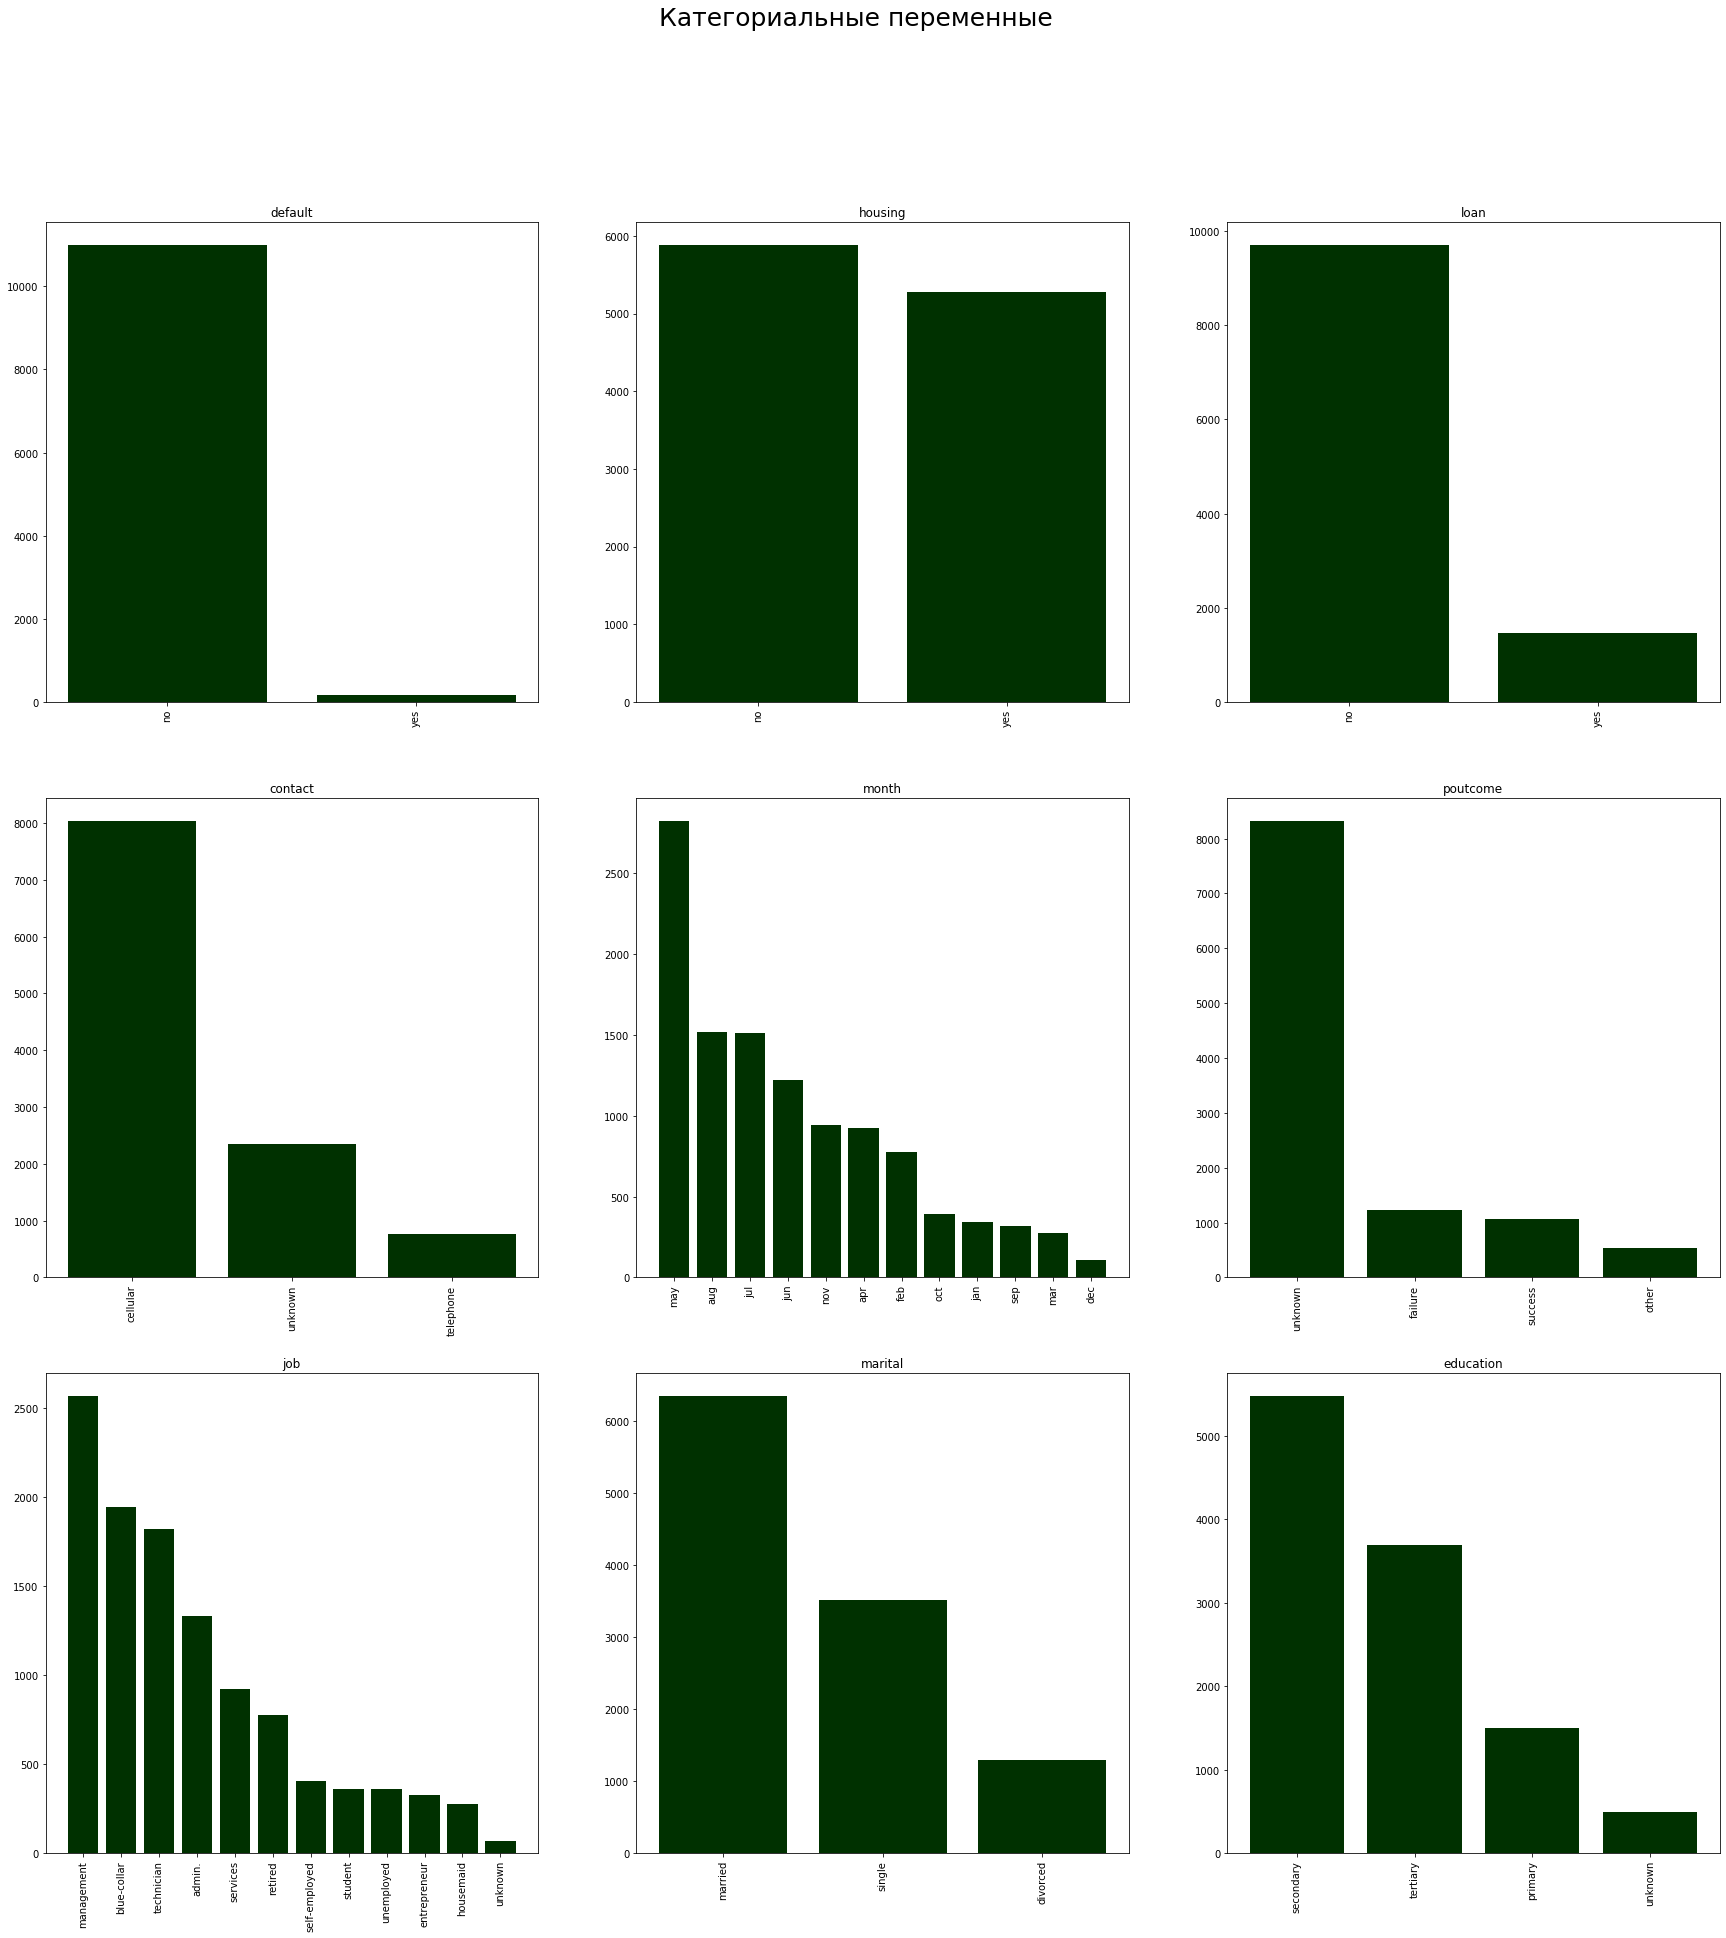

In [10]:
cat_columns = ['default','housing', 'loan', 'contact', 'month','poutcome', 'job', 'marital', 'education']
fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(30, 30))
plt.suptitle('Категориальные переменные', fontsize = 25)
counter = 0
colors = '#003100'
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index, color = colors)
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

Выбросов и аномалий выявлено не было, теперь посмотрим числовые предикторы.

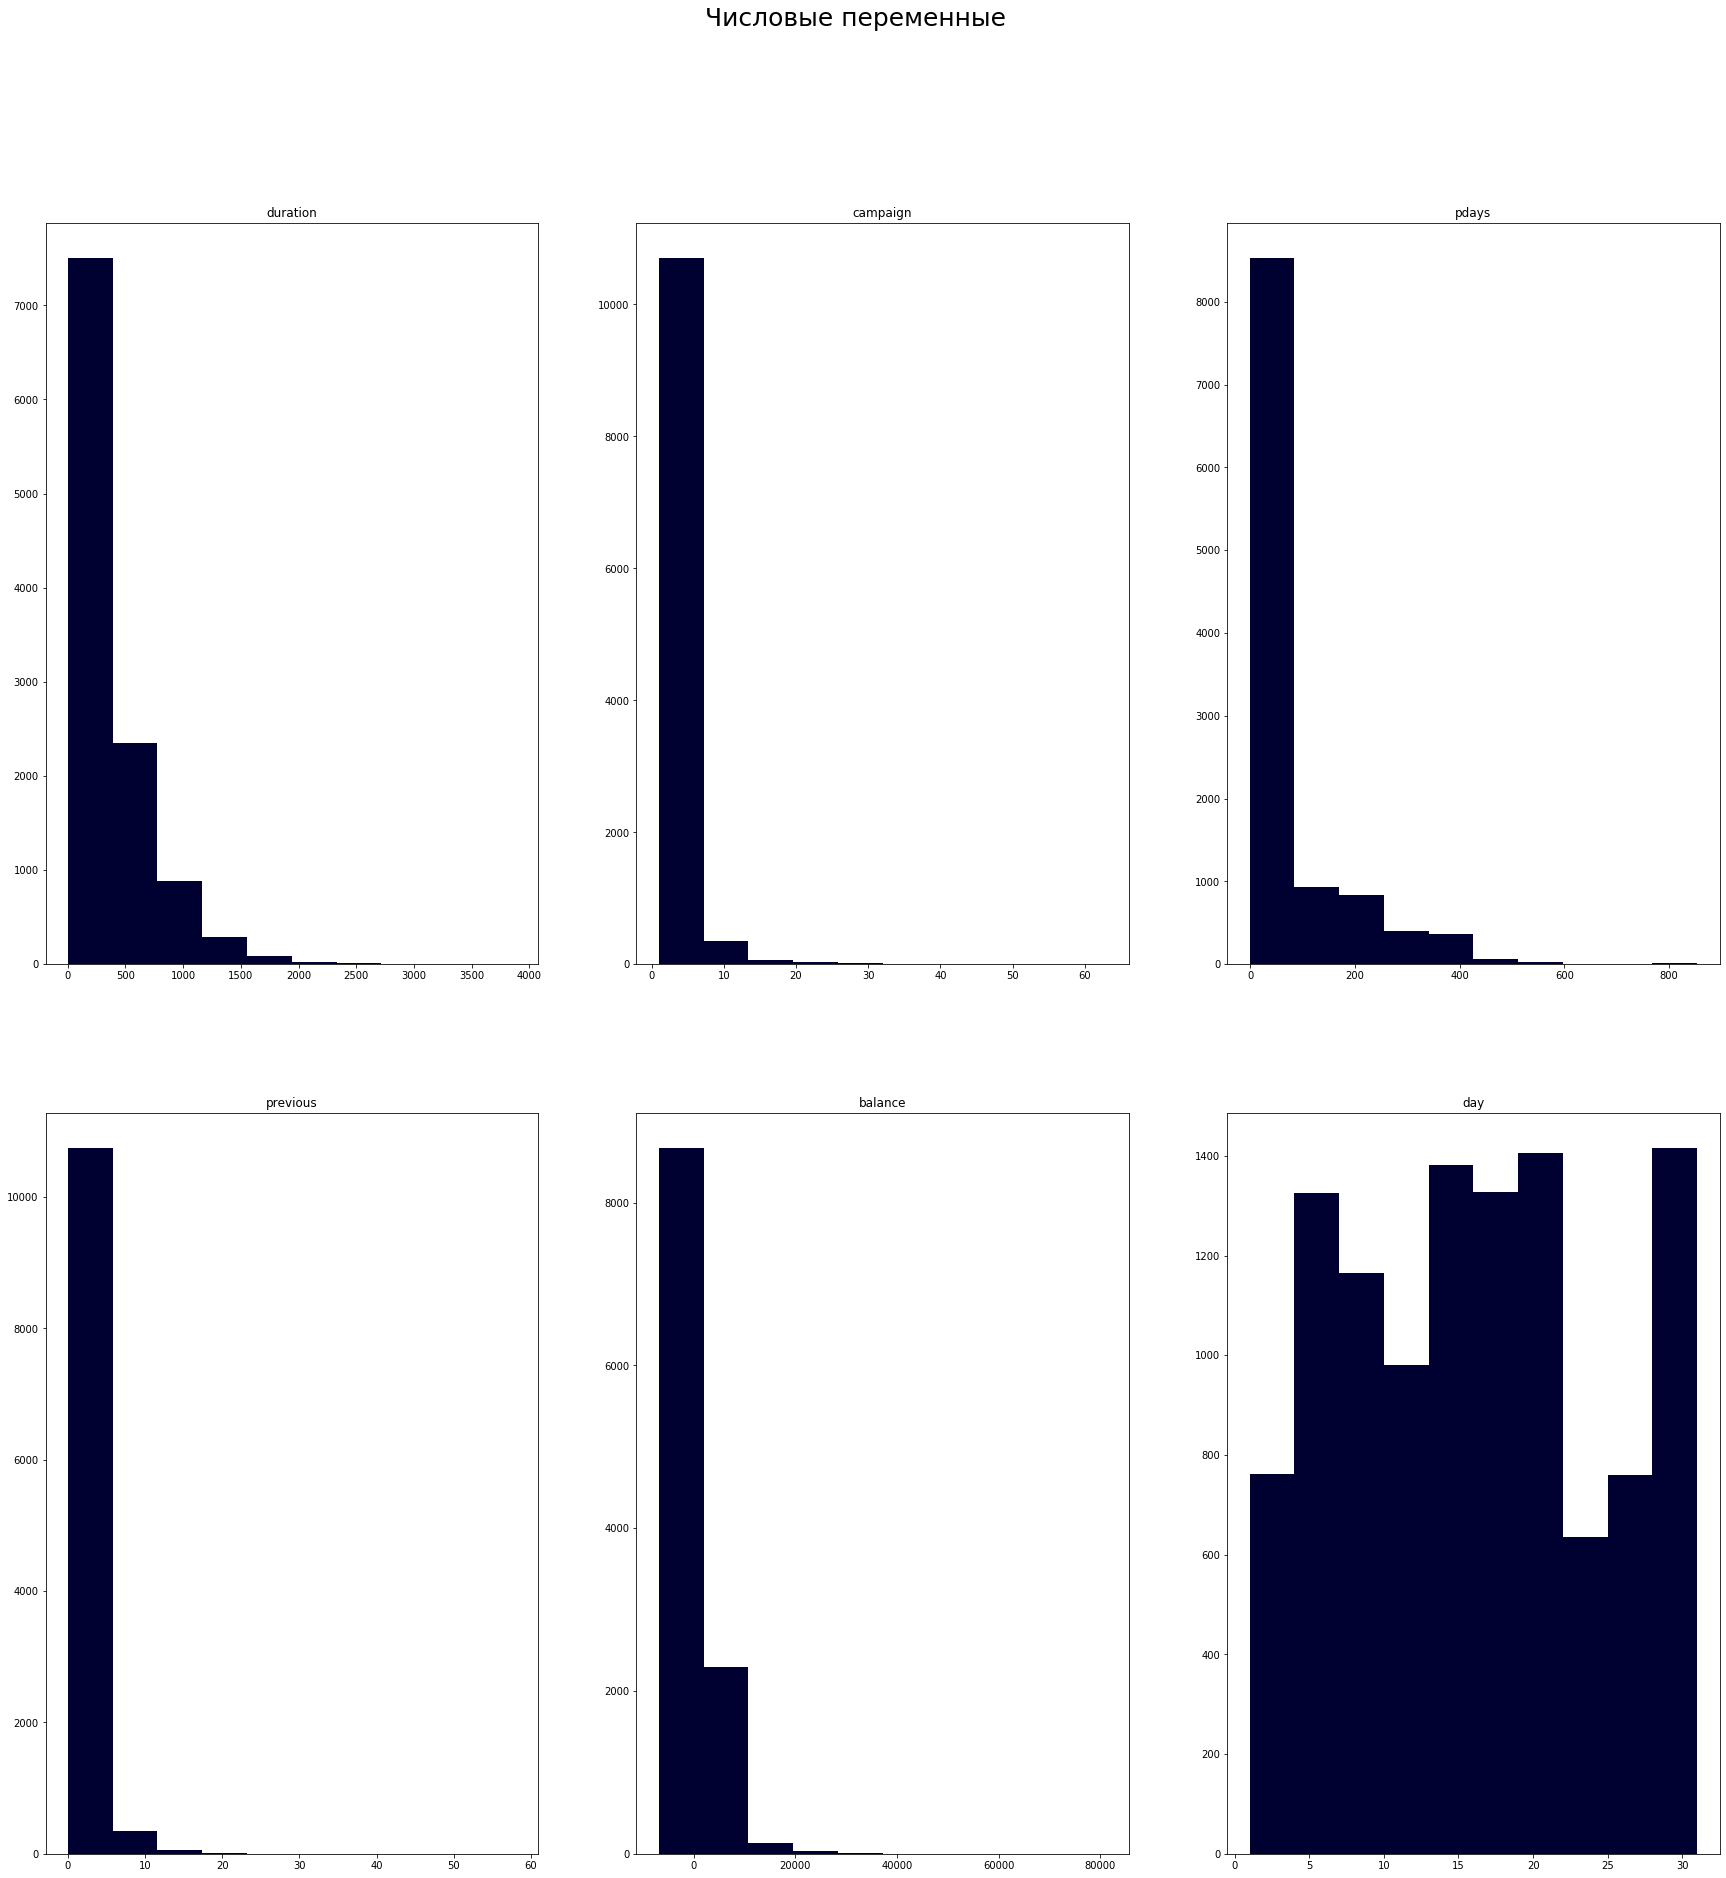

In [11]:
num_columns = ['duration', 'campaign', 'pdays', 'previous', 'balance', 'day']
fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(30, 30))
plt.suptitle('Числовые переменные', fontsize = 25)
colors = '#000031'
counter = 0
for num_column in num_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    axs[trace_x, trace_y].hist(df[num_column], color = colors)
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

В числовых переменных мы видим выбросы в параметрах: duration, pdays, campaign, previous, balance.

In [12]:
#посмотрим на данные duration

df[['duration']].describe()

,duration
count,11162.000000
mean,371.993818
std,347.128386
min,2.000000
25%,138.000000
50%,255.000000
75%,496.000000
max,3881.000000


In [13]:
#посчитаем сколько значений более 1500

len (df[df['duration'] > 1500] ) / len(df) * 100

1.3348862211073285

Опираясь на график видим резкое снижение кол-ва длинных разговоров. Всего 1,33% записей имеют длительность разговора от 1500 до 3881 сек. При чистке заменим их на среднее (mean).

In [14]:
#посмотрим на данные pdays

df[['pdays']].describe()

,pdays
count,11162.000000
mean,51.330407
std,108.758282
min,-1.000000
25%,-1.000000
50%,-1.000000
75%,20.750000
max,854.000000


In [15]:
#посмотрим сколько записей с значением -1

len (df[df['pdays'] == -1] ) / len(df) * 100

74.5744490234725

Значение -1 соответствует ситуации, когда с клиентом ранее не связывались, таких записей около 75%, поэтому при чистке можно удалить этот столбец.


In [16]:
#посмотрим на данные campaign

df[['campaign']].describe()

,campaign
count,11162.000000
mean,2.508421
std,2.722077
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,63.000000


In [17]:
#посчитаем сколько значений более 20

len (df[df['campaign'] > 20] ) / len(df) * 100

0.3762766529295825

Можно предположить, что по одной сделке вряд ли банк будет контактировать с клиентом более 20 раз. Это подтверждают и расчеты, всего 0,38% записей со значениями от 20 до 63. При чистке заменим их на среднее (mean).

In [18]:
#посмотрим на данные previous

df[['previous']].describe()

,previous
count,11162.000000
mean,0.832557
std,2.292007
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,58.000000


In [19]:
#посчитаем сколько значений более 20

len (df[df['previous'] > 20] ) / len(df) * 100

0.13438451890342232

Количество предыдущих контактов так же вряд ли может достигать 58, заменим значения больше 20 при чистке на среднее (mean).

In [20]:
#посмотрим на данные balance

df[['balance']].describe()

,balance
count,11162.000000
mean,1528.538524
std,3225.413326
min,-6847.000000
25%,122.000000
50%,550.000000
75%,1708.000000
max,81204.000000


С учетом того, что баланс действительно может очень сильно различаться, не будем считать это выбросом.

Итог поиска аномалий: избавляемся от колонки pdays, используем замену на среднее в duration (>1500), campaign (>20), previous (>20).

Теперь необходимо проследить наличие корреляции между признаками.

In [21]:
#разделим данные и построим диаграммы

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(df.drop("deposit",axis=1), df.deposit):
    traindf=df.loc[train_index]
    testdf= df.loc[test_index]
    
traindf2=traindf.copy()
traindf3=traindf.copy()

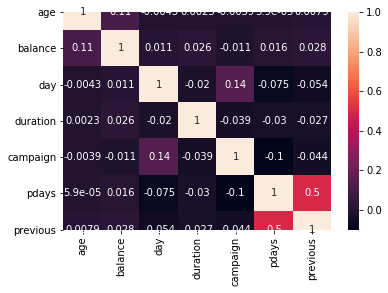

In [22]:
#проверим наличие корреляции методом Пирсона для числовых

sns.heatmap(traindf.corr(method='pearson'), annot=True)

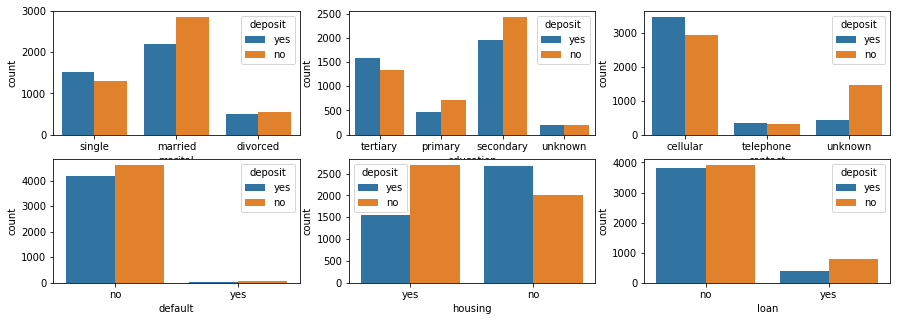

In [23]:
#теперь посмотрим на корреляцию категориальных признаков

plt.figure(figsize=[15,5])
plt.subplot(2,3,1)
sns.countplot(x='marital', hue='deposit', data=traindf)
plt.subplot(2,3,2)
sns.countplot(x='education', hue='deposit', data=traindf)
plt.subplot(2,3,3)
sns.countplot(x='contact', hue='deposit', data=traindf)
plt.subplot(2,3,4)
sns.countplot(x='default', hue='deposit', data=traindf)
plt.subplot(2,3,5)
sns.countplot(x='housing', hue='deposit', data=traindf)
plt.subplot(2,3,6)
sns.countplot(x='loan', hue='deposit', data=traindf)
plt.show()

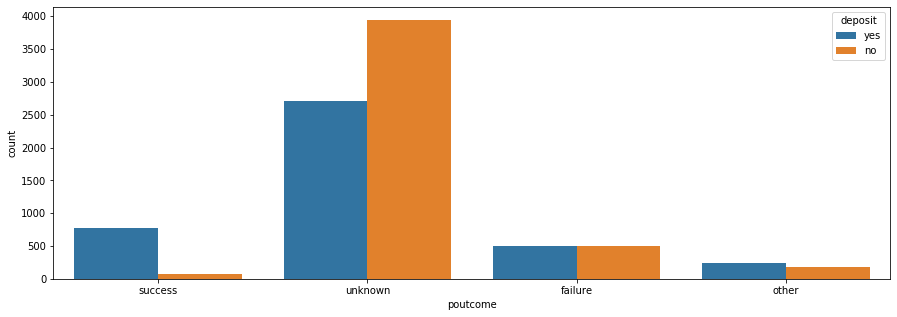

In [24]:
plt.figure(figsize=[15,5])
sns.countplot(x='poutcome', hue='deposit', data=traindf)

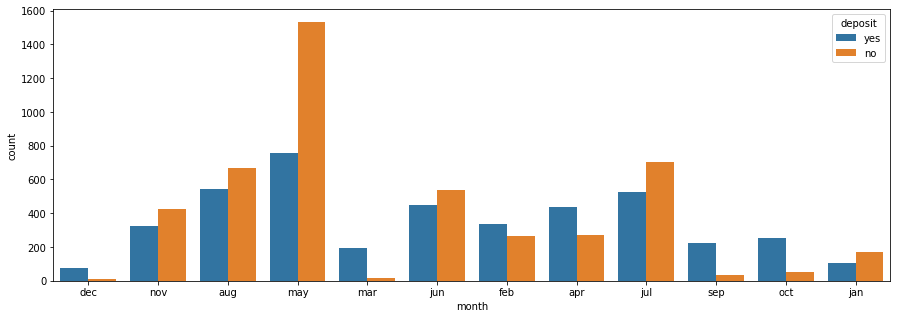

In [25]:
plt.figure(figsize=[15,5])
sns.countplot(x='month', hue='deposit', data=traindf)

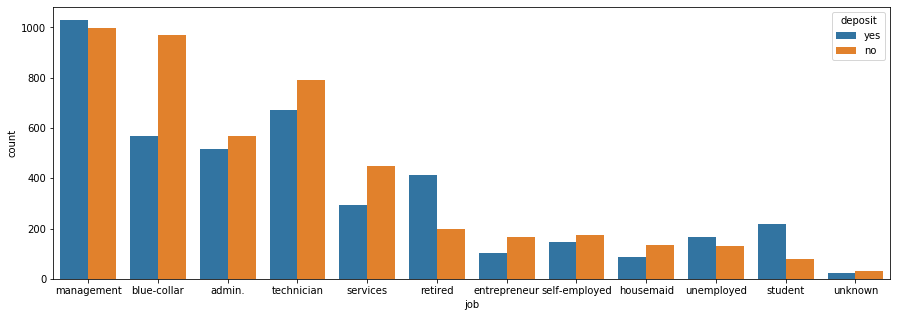

In [26]:
plt.figure(figsize=[15,5])
sns.countplot(x='job', hue='deposit', data=traindf)

Вывод по графикам:
- Клиенты с жилищными кредитами обычно говорят "нет" на срочный депозит.
- Люди в браке чаще всего отказывают.
- В мае люди чаще отказывают, а соглашаются чаще в декабре, марте, сентябре и октябре.
- Рабочие и техники чаще всего говорят "нет", а пенсионеры и студенты соглашаются.

По итогам анализа не выявлено избыточных параметров, переходим к чистке. Также приведем категориальные и бинарные переменные к числам.

In [27]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    
    cleaned_df = df.copy()
    
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = bool_columns)
    
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['pdays'])
    
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 20, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 20, cleaned_df),axis=1)
    cleaned_df['duration_cleaned'] = df.apply(lambda row: get_correct_values(row, 'duration', 1500, cleaned_df),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous', 'duration'])
    
    return cleaned_df

In [28]:
#чистка

cleaned_df = clean_data(df)
cleaned_df.head()

,age,balance,day,default_bool,housing_bool,loan_bool,deposit_bool,job_blue-collar,job_entrepreneur,job_housemaid,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned,duration_cleaned
0,59,2343,5,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,1.0,0.0,1042.0
1,56,45,5,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,1.0,0.0,1467.0
2,41,1270,5,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,1.0,0.0,1389.0
3,55,2476,5,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,1.0,0.0,579.0
4,54,184,5,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,2.0,0.0,673.0


Теперь попробуем применить метод градиентной регрессии в реализации xgboost.

In [29]:
#разделим на тестовую и тренировочную часть
X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]
TEST_SIZE = 0.3
RAND_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

#тренируем модель
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=8)
xgb.fit(X_train,y_train.squeeze().values)

#предсказываем
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('Точность:', accuracy_score(y_test, y_test_preds))

Точность: 0.8527918781725888


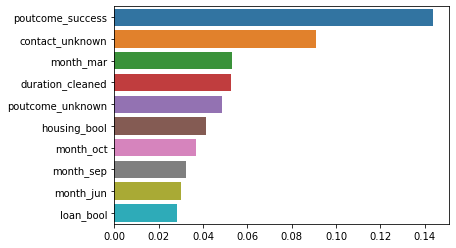

In [30]:
#посмотрим на зависимости параметров

importances = xgb.feature_importances_
feature_importances = pd.Series(importances, index = X_train.columns).sort_values(ascending=False)
sns.barplot(x = feature_importances[0:10], y = feature_importances.index[0:10])
plt.show()

Получили хорошую точность алгоритма, теперь попробуем использовать случайный лес в GridSearchCV.

In [31]:
RF = RandomForestClassifier(random_state=1)
PRF = [{'n_estimators':[10, 50, 100, 500],'max_depth':[3,6,9],'criterion':['gini','entropy']}]
gs = GridSearchCV(estimator=RF, param_grid=PRF, scoring='accuracy',cv=5,n_jobs=-1)
gs.fit(X_train, y_train)

MODEL = gs.best_estimator_.fit(X_train, y_train)
preds = MODEL.predict(X_test)
print('Точность:', accuracy_score(y_test, preds))

Точность: 0.826515377724694


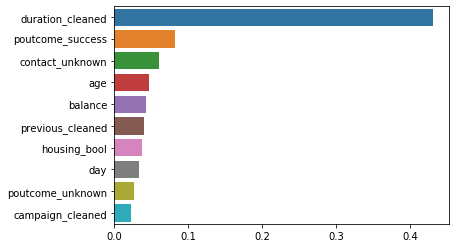

In [32]:
#посмотрим на зависимости параметров

importances = MODEL.feature_importances_
feature_importances = pd.Series(importances, index = X_train.columns).sort_values(ascending=False)
sns.barplot(x = feature_importances[0:10], y = feature_importances.index[0:10])
plt.show()

Получили хорошую точность, но меньше, чем xgboost. Попробуем использовать более простые алгоритмы.

In [33]:
#попробуем логистическую регрессию
lr = LogisticRegression()

log_scores = cross_val_score(lr, X_train, y_train, cv=3)
log_reg_mean = log_scores.mean()
print('Точность:', log_reg_mean)

Точность: 0.8192752819865693


In [34]:
#попробуем алгоритм knn
knn = KNeighborsClassifier(n_neighbors=5)

knn_scores = cross_val_score(knn, X_train, y_train, cv=3)
knn_mean = knn_scores.mean()
print('Точность:', knn_mean)

Точность: 0.7042107570124411


In [35]:
#попробуем градиентный бустинг
grad_clf = GradientBoostingClassifier()

grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()
print('Точность:', grad_mean)

Точность: 0.841290430687372


In [36]:
#попробуем дерево решений
tree_clf = tree.DecisionTreeClassifier()

tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
tree_mean = tree_scores.mean()
print('Точность:', tree_mean)

Точность: 0.77690835399646


In [37]:
#попробуем алгоритм MLP (многослойный персептрон)
neural_clf = MLPClassifier(alpha=1)

neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()
print('Точность:', neural_mean)

Точность: 0.7211064133824334


Как мы и ожидали, более сложные, "продвинутые" алгоритмы дают более точный результат обучения, "победителем" становится xgboost. 

Еще раз проанализаровав все графики можно сделать вывод, что на решение клиента больше всего влияют:
- баланс счета 
- возраст 
- количество контактов, выполненных во время этой кампании
- продолжительность контакта
- количество контактов, выполненных до этой кампании. 

Таким образом можно составить "идеальную ситуацию" для предложения срочного депозита:
- клиент в предпенсионном и пенсионном возрасте 
- клиент уже общался с банком до этой сделки
- у клиента высокий баланс на счету
- клиент не женат
- клиент не является представителем рабочего класса
- клиент выполняет несколько продолжительных контактов во время операции